In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
df = pd.read_csv("team_traditional.csv")
df = df[(df["season"] >= 2020) & (df["type"] == "regular")].reset_index(drop=True)

# Keep base columns
df = df[[
    "gameid", "date", "team", "home", "away",
    "PTS", "FGM", "FGA", "FG%", "3PM", "3PA", "3P%",
    "FTM", "FTA", "FT%", "OREB", "DREB", "REB",
    "AST", "TOV", "STL", "BLK", "PF"
]].copy()

# Home flag
df["is_home"] = (df["team"] == df["home"]).astype(int)

# Split home vs away
home = df[df["is_home"] == 1].copy()
away = df[df["is_home"] == 0].copy()

# Merge into one row per game
games = home.merge(away, on="gameid", suffixes=("_home", "_away"))

# Rename for clarity
games = games.rename(columns={
    "team_home": "home_team",
    "team_away": "away_team",
    "PTS_home": "home_PTS",
    "PTS_away": "away_PTS"
})

# Date + sorting
games["date"] = pd.to_datetime(games["date_home"])
games = games.sort_values("date")

# True Shooting %
games["TS_home"] = games["home_PTS"] / (
    2 * (games["FGA_home"] + 0.44 * games["FTA_home"])
)
games["TS_away"] = games["away_PTS"] / (
    2 * (games["FGA_away"] + 0.44 * games["FTA_away"])
)

# Fix inf / NaN
games["TS_home"] = games["TS_home"].replace([np.inf, -np.inf], np.nan)
games["TS_away"] = games["TS_away"].replace([np.inf, -np.inf], np.nan)
games["TS_home"] = games["TS_home"].fillna(games["TS_home"].mean())
games["TS_away"] = games["TS_away"].fillna(games["TS_away"].mean())

# Target variable
games["TOTAL_POINTS"] = games["home_PTS"] + games["away_PTS"]

# Label encode categorical variables
le_home = LabelEncoder()
le_away = LabelEncoder()

games["home_team_enc"] = le_home.fit_transform(games["home_team"])
games["away_team_enc"] = le_away.fit_transform(games["away_team"])

# FINAL FEATURE SET
final_df = games[[
    "gameid", "date",

    # Encoded teams
    "home_team_enc", 
    "away_team_enc",

    # Shooting efficiency & pace
    "TS_home", "TS_away",
    "FGA_home", "FGA_away",

    # Possession/control
    "REB_home", "REB_away",
    "AST_home", "AST_away",
    "TOV_home", "TOV_away",

    # Target
    "home_PTS", "away_PTS",
    "TOTAL_POINTS"
]]

final_df.head(), final_df.shape

(     gameid       date  home_team_enc  away_team_enc   TS_home   TS_away  \
 0  21900001 2019-10-22             27             18  0.542934  0.550542   
 1  21900002 2019-10-22             12             13  0.611621  0.541171   
 2  21900003 2019-10-23              3              4  0.662879  0.544995   
 3  21900004 2019-10-23             11              8  0.552431  0.643104   
 4  21900005 2019-10-23             21              5  0.498092  0.449260   
 
    FGA_home  FGA_away  REB_home  REB_away  AST_home  AST_away  TOV_home  \
 0     103.0     102.0      57.0      53.0      23.0      30.0      17.0   
 1      81.0      85.0      45.0      41.0      24.0      20.0      14.0   
 2      88.0     105.0      41.0      49.0      28.0      25.0      19.0   
 3      89.0      78.0      36.0      45.0      26.0      26.0      15.0   
 4      86.0      88.0      46.0      54.0      24.0      20.0      13.0   
 
    TOV_away  home_PTS  away_PTS  TOTAL_POINTS  
 0      19.0     130.0     12

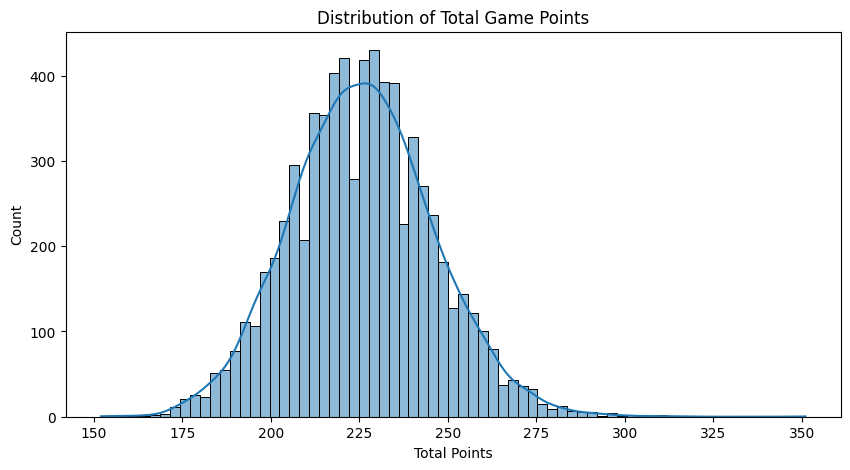

In [21]:
plt.figure(figsize=(10,5))
sns.histplot(final_df["TOTAL_POINTS"], kde=True)
plt.title("Distribution of Total Game Points")
plt.xlabel("Total Points")
plt.show()

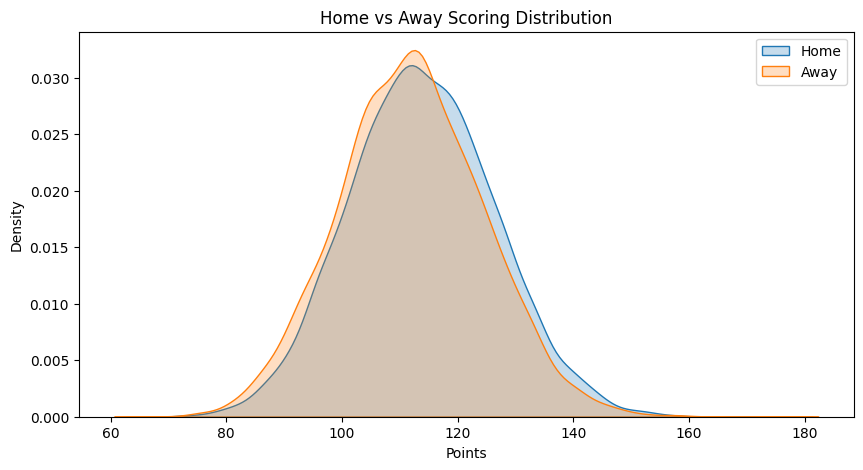

In [22]:
plt.figure(figsize=(10,5))
sns.kdeplot(final_df["home_PTS"], label="Home", fill=True)
sns.kdeplot(final_df["away_PTS"], label="Away", fill=True)
plt.title("Home vs Away Scoring Distribution")
plt.xlabel("Points")
plt.legend()
plt.show()

In [23]:
numeric_df = final_df.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_df.corr().abs()

upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

threshold = 0.85
to_drop = [col for col in upper.columns if any(upper[col] > threshold)]

reduced_df = final_df.drop(columns=to_drop)

print("Dropped columns:", to_drop)
print("Remaining columns:", reduced_df.columns)

Dropped columns: []
Remaining columns: Index(['gameid', 'date', 'home_team_enc', 'away_team_enc', 'TS_home',
       'TS_away', 'FGA_home', 'FGA_away', 'REB_home', 'REB_away', 'AST_home',
       'AST_away', 'TOV_home', 'TOV_away', 'home_PTS', 'away_PTS',
       'TOTAL_POINTS'],
      dtype='object')


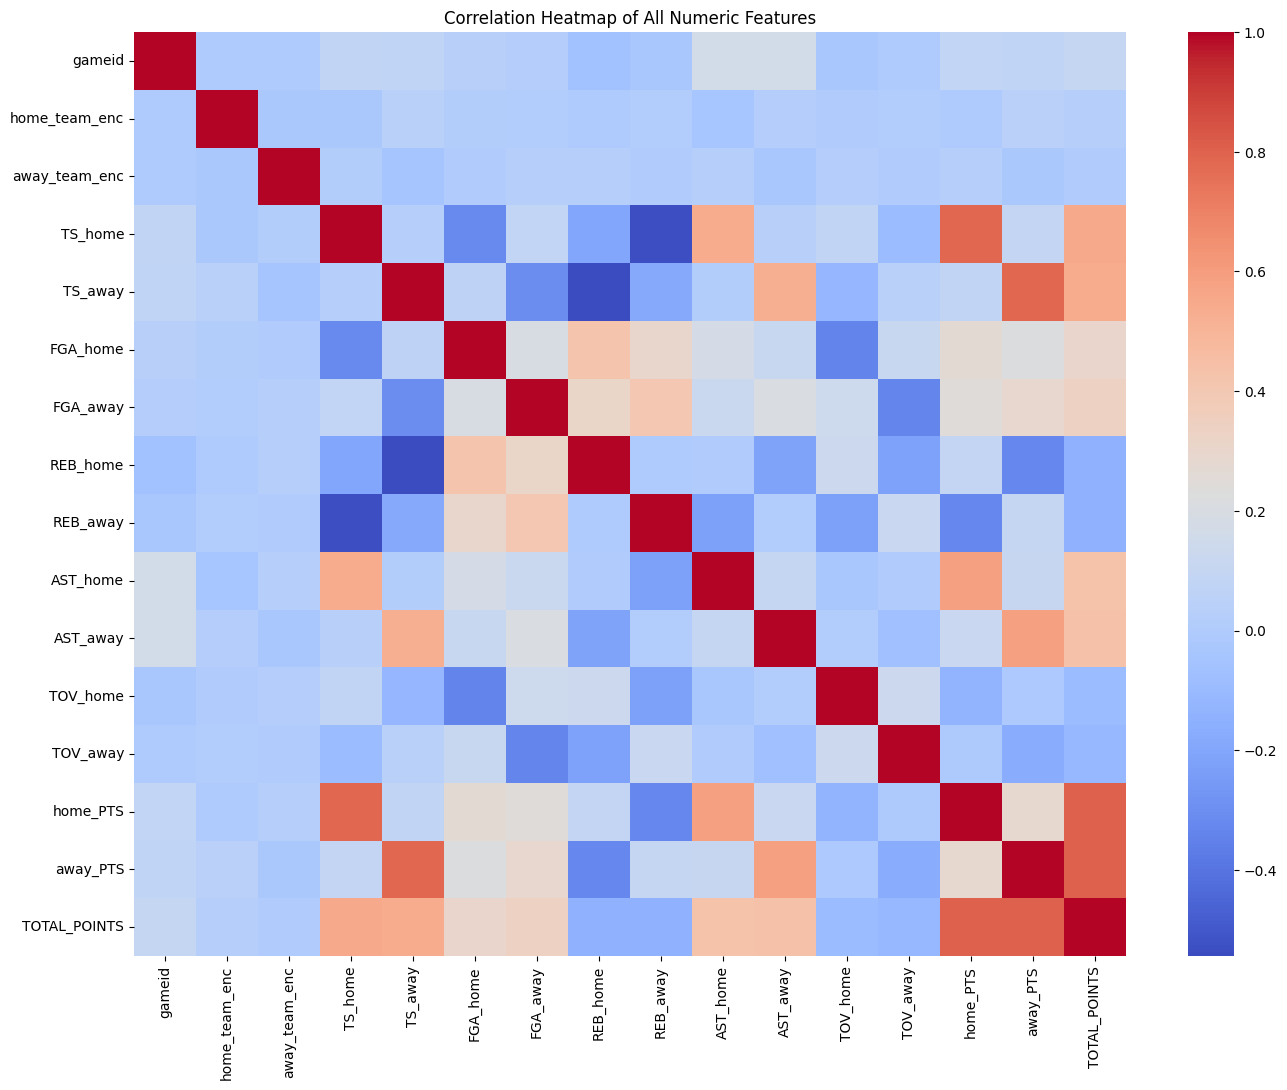

In [24]:
numeric_only = reduced_df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(16, 12))
sns.heatmap(numeric_only.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap of All Numeric Features")
plt.show()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

feature_cols = [
    "home_team_enc",
    "away_team_enc",
    "TS_home", "TS_away",
    "FGA_home", "FGA_away",
    "REB_home", "REB_away",
    "AST_home", "AST_away",
    "TOV_home", "TOV_away"
]

X = final_df[feature_cols].values.astype(np.float32)
y = final_df["TOTAL_POINTS"].values.astype(np.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=439
)

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_scale = y_train.max()
y_train_scaled = y_train / y_scale
y_test_scaled  = y_test / y_scale

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert data to torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)

X_test_t  = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

# Create test_loader for validation

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

import torch.nn as nn
import torch.optim as optim

input_dim = X_train_scaled.shape[1]

class ScoreNet(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 216),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(216, 1)
        )
    def forward(self, x):
        return self.net(x)

model = ScoreNet(input_dim).to(device)

# Huber-style loss 
criterion = nn.HuberLoss(delta=1.0)
# Use Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# TRAINING LOOP
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # ---- TRAIN ----
    model.train()
    running_train = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_train += loss.item() * xb.size(0)

    epoch_train_loss = running_train / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ---- VALIDATION ----
    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb)
            loss = criterion(preds, yb)
            running_val += loss.item() * xb.size(0)

    epoch_val_loss = running_val / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(
        f"Epoch {epoch+1}/{num_epochs} "
        f"- Train Loss (scaled): {epoch_train_loss:.4f} "
        f"- Val Loss (scaled): {epoch_val_loss:.4f}"
    )

Epoch 1/50 - Train Loss (scaled): 0.0112 - Val Loss (scaled): 0.0005
Epoch 2/50 - Train Loss (scaled): 0.0030 - Val Loss (scaled): 0.0003
Epoch 3/50 - Train Loss (scaled): 0.0027 - Val Loss (scaled): 0.0002
Epoch 4/50 - Train Loss (scaled): 0.0024 - Val Loss (scaled): 0.0003
Epoch 5/50 - Train Loss (scaled): 0.0023 - Val Loss (scaled): 0.0005
Epoch 6/50 - Train Loss (scaled): 0.0021 - Val Loss (scaled): 0.0001
Epoch 7/50 - Train Loss (scaled): 0.0020 - Val Loss (scaled): 0.0004
Epoch 8/50 - Train Loss (scaled): 0.0019 - Val Loss (scaled): 0.0002
Epoch 9/50 - Train Loss (scaled): 0.0017 - Val Loss (scaled): 0.0002
Epoch 10/50 - Train Loss (scaled): 0.0018 - Val Loss (scaled): 0.0002
Epoch 11/50 - Train Loss (scaled): 0.0017 - Val Loss (scaled): 0.0002
Epoch 12/50 - Train Loss (scaled): 0.0016 - Val Loss (scaled): 0.0001
Epoch 13/50 - Train Loss (scaled): 0.0015 - Val Loss (scaled): 0.0002
Epoch 14/50 - Train Loss (scaled): 0.0015 - Val Loss (scaled): 0.0003
Epoch 15/50 - Train Loss (sca

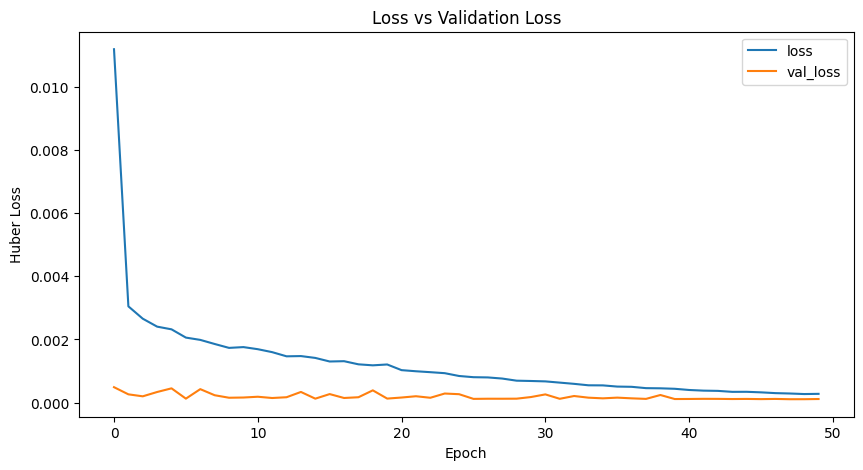

In [28]:
loss_df = pd.DataFrame({
    "loss": train_losses,
    "val_loss": val_losses
})

loss_df.plot(figsize=(10,5))
plt.title("Loss vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Huber Loss")
plt.show()

In [31]:
model.eval()

# Forward pass
with torch.no_grad():
    preds_scaled = model(X_test_t).cpu().numpy().flatten()
predictions = preds_scaled * y_scale
y_true = y_test.flatten()

mae = mean_absolute_error(y_true, predictions)
mse = mean_squared_error(y_true, predictions)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)

MAE: 4.215805530548096
MSE: 28.096967697143555
RMSE: 5.300657289161746


In [33]:
print(predictions[:20])
print("Pred mean:", predictions.mean())
print("True mean:", y_true.mean())

[232.24353 301.23526 243.41719 200.1083  232.19905 230.10574 241.407
 201.86685 249.66492 202.1773  220.22197 262.29776 211.38234 229.76741
 216.06425 228.29196 202.78433 204.6974  203.61893 202.12337]
Pred mean: 225.8506
True mean: 225.68494


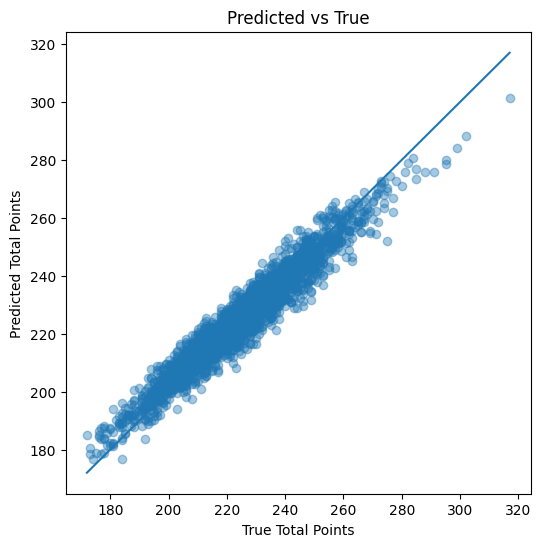

In [35]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, predictions, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("True Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Predicted vs True")
plt.show()